In [1]:
import pandas as pd
import numpy as np
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Importing dataset

In [2]:
df_review=pd.read_csv('UMICH_SI650_Sentiment_Classification.txt', header=None, delimiter="\t", quoting=3)
df_review.head()

,0,1
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


# 1. Working with dataset

In [3]:
df_review.columns=["Liked", "Text"]

In [4]:
df_review.head()

,Liked,Text
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [5]:
df_review.Liked.value_counts()

1    3995
0    3091
Name: Liked, dtype: int64

In [6]:
# et's calculate the average number of words per sentence. We could do the following using a list
# comprehension with the number of words per sentence

np.mean([len(s.split(" ")) for s in df_review.Text])

10.886819079875812

## Cleaning

In [7]:
corpus = [] # defining corpus
for i in range(0, len(df_review['Text'])): # giving range of values from 0 to 1000
    review = re.sub('[^a-zA-Z]', ' ', df_review['Text'][i]) # using i for all values instead of 1 column
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    stopword_set = set(stopwords.words('english'))
    review = [ps.stem(word) for word in review if not word in stopword_set]
    review = ' '.join(review)
    corpus.append(review) # finally attach all these cleaned values to corpus directory 

## Splitting data into test and train

In [8]:
corpus_series = pd.Series(corpus)

X=corpus_series

In [9]:
y=df_review['Liked']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Vectorize

In [11]:
count_vectorizer = CountVectorizer(max_features=85,stop_words='english')
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=85, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
count_train_mat = count_vectorizer.fit_transform(X_train)
type(count_train_mat)


scipy.sparse.csr.csr_matrix

In [13]:
count_train = count_vectorizer.fit_transform(X_train).toarray()
type(count_train)

numpy.ndarray

In [14]:
count_test = count_vectorizer.transform(X_test)
type(count_test)

scipy.sparse.csr.csr_matrix

### Vocab

In [15]:
# Take a look at the words in the vocabulary
vocab = count_vectorizer.get_feature_names()
print (vocab)

['absolut', 'alway', 'awesom', 'beauti', 'better', 'big', 'bonker', 'book', 'bore', 'brokeback', 'charact', 'code', 'cool', 'cowboy', 'da', 'daniel', 'depress', 'die', 'felicia', 'film', 'freakin', 'friday', 'fuck', 'gay', 'good', 'got', 'great', 'guy', 'harri', 'hate', 'heard', 'hill', 'horribl', 'imposs', 'insan', 'joke', 'know', 'left', 'like', 'love', 'main', 'make', 'man', 'mission', 'mom', 'mountain', 'movi', 'need', 'oh', 'ok', 'opinion', 'peopl', 'person', 'potter', 'read', 'realli', 'review', 'right', 'rock', 'said', 'saw', 'say', 'seen', 'sentri', 'seri', 'stand', 'start', 'station', 'stori', 'stupid', 'suck', 'terribl', 'thing', 'think', 'thought', 'time', 'tom', 'turn', 'type', 'vinci', 'want', 'watch', 'way', 'went', 'yeah']


In [16]:
# Sum up the counts of each vocabulary word
dist = np.sum(count_train, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in list(zip(vocab, dist)):
    print (count, tag)

85 absolut
69 alway
926 awesom
96 beauti
75 better
83 big
70 bonker
130 book
72 bore
1577 brokeback
72 charact
1612 code
71 cool
74 cowboy
1611 da
69 daniel
139 depress
72 die
134 felicia
83 film
69 freakin
69 friday
148 fuck
74 gay
97 good
77 got
78 great
129 guy
1678 harri
566 hate
78 heard
68 hill
144 horribl
886 imposs
68 insan
68 joke
283 know
139 left
907 like
1505 love
71 main
131 make
70 man
887 mission
69 mom
1577 mountain
895 movi
69 need
140 oh
129 ok
71 opinion
141 peopl
77 person
1678 potter
239 read
288 realli
70 review
201 right
132 rock
78 said
84 saw
94 say
69 seen
70 sentri
144 seri
69 stand
129 start
70 station
145 stori
290 stupid
1199 suck
145 terribl
79 thing
175 think
74 thought
87 time
81 tom
69 turn
69 type
1611 vinci
264 want
159 watch
80 way
94 went
138 yeah


# 2.Finding most accurate model

### i- SVC

In [17]:
# We can use sklearn algorithms in NLTK
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC

svc_clf = SVC(kernel='linear', random_state=0)

# train the model on the training data
svc_clf.fit(count_train_mat, y_train)
pred = svc_clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.986


### confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.<br>
Key matrix elements are:<br>
true positives (TP): These are cases in which we predicted yes (they have the purchased), and they do have the purchases.<br>
true negatives (TN): We predicted no, and they don't have purchased.<br>
false positives (FP): We predicted yes, but they have actually not the purchased. (Also known as a "Type I error.")<br>
false negatives (FN): We predicted no, but they actually ourchased. (Also known as a "Type II error.")<br>

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

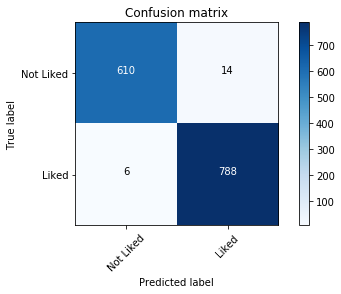

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Not Liked', 'Liked'])

### ii- Naive-Bayes Model

In [20]:
nb_clf = MultinomialNB(alpha=0.1)

nb_clf.fit(count_train, y_train)
pred = nb_clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.981


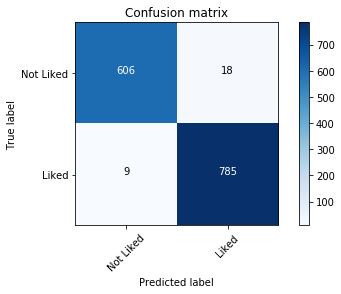

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Not Liked', 'Liked'])

In [22]:
df_review.Text[120]

'I love the Da Vinci Code.'

In [23]:
movie_reviews_array=np.array(["I love the Da Vinci Code."])
movie_review_vector=count_vectorizer.transform(movie_reviews_array)
print(nb_clf.predict(movie_review_vector))

[1]


**It shows our model predicts well. We can test for other model as well to check different results' combination.**

### iii-Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt_clf=DecisionTreeClassifier(criterion='entropy', random_state=0)

dt_clf.fit(count_train, y_train)
pred = dt_clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.987


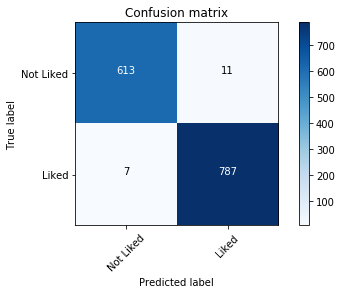

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Not Liked', 'Liked'])

### iv- Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rf_clf.fit(count_train, y_train)
pred = rf_clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.987


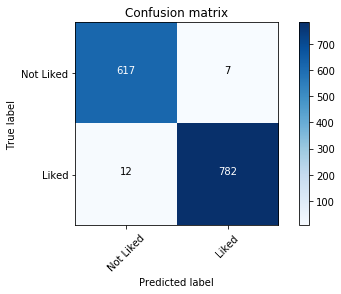

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Not Liked', 'Liked'])

### v-SGD

In [28]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()

sgd_clf.fit(count_train, y_train)
pred = sgd_clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.989


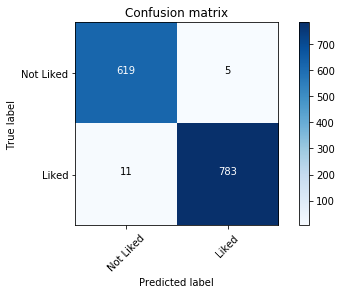

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['Not Liked', 'Liked'])

In [30]:
from sklearn.ensemble import VotingClassifier
evc=VotingClassifier(estimators=[('Naive_Bayes', nb_clf),('decision_tree', dt_clf),('Random_Forest', rf_clf),('SGD',sgd_clf)], voting='hard')


In [31]:
evc.fit(count_train, y_train)

VotingClassifier(estimators=[('Naive_Bayes', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)), ('decision_tree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [32]:
y_test.shape

(1418,)

In [33]:
count_test.shape

(1418, 85)

In [34]:
evc.score(count_test, y_test)

0.9858956276445698

# 3. Sentiment Analysis of tweets

In [35]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

### checking most common words used

In [36]:
from wordcloud import WordCloud, STOPWORDS

In [37]:
stopwords=set(STOPWORDS)

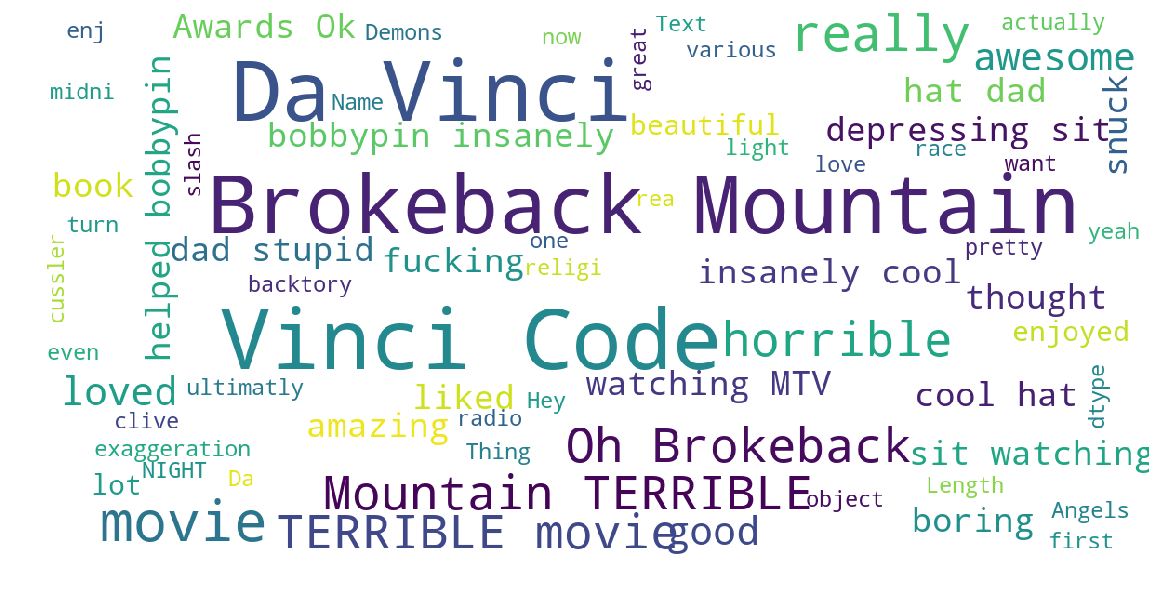

In [47]:
def Mywordcloud (data, title=None):
    wordcloud=WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words= 200 ,
    max_font_size=30 ,
    scale=3,
    random_state=1
    ).generate(str(data))
    
    fig=plt.figure(1 , figsize(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()

Mywordcloud(df_review["Text"].dropna())

**Using vader lexicon for sentiment analysis**

In [39]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)
sid= SentimentIntensityAnalyzer()

In [40]:
df_review['Sent_compound_Polarity'] = df_review.Text.apply(lambda x:sid.polarity_scores(x)['compound'])
df_review['Sent_neutral']= df_review.Text.apply(lambda x:sid.polarity_scores(x)['neu'])
df_review['Sent_Neg']= df_review.Text.apply (lambda x:sid.polarity_scores(x)['neg'])
df_review['Sent_pos']= df_review.Text.apply(lambda x:sid.polarity_scores(x)['pos'])
df_review['Sent_type']=''

In [41]:
df_review.transpose()

,0,1,2,3,4,5,6,7,8,9,...,7076,7077,7078,7079,7080,7081,7082,7083,7084,7085
Liked,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Text,The Da Vinci Code book is just awesome.,this was the first clive cussler i've ever rea...,i liked the Da Vinci Code a lot.,i liked the Da Vinci Code a lot.,I liked the Da Vinci Code but it ultimatly did...,that's not even an exaggeration ) and at midni...,"I loved the Da Vinci Code, but now I want some...","i thought da vinci code was great, same with k...",The Da Vinci Code is actually a good movie...,I thought the Da Vinci Code was a pretty good ...,...,Brokeback Mountain is fucking horrible..,"Then snuck into Brokeback Mountain, which is t...",", she helped me bobbypin my insanely cool hat ...",My dad's being stupid about brokeback mountain...,"Oh, and Brokeback Mountain is a TERRIBLE movie...",Brokeback Mountain was boring.,So Brokeback Mountain was really depressing.,"As I sit here, watching the MTV Movie Awards, ...",Ok brokeback mountain is such a horrible movie.,"Oh, and Brokeback Mountain was a terrible movie."
Sent_compound_Polarity,0.6249,0.5023,0.4215,0.4215,0.2263,0.5859,0.793,0.6249,0.4404,0.7269,...,0,-0.4391,0.2263,-0.5267,-0.5904,-0.3182,-0.4391,0.0772,-0.3182,-0.4767
Sent_neutral,0.631,0.871,0.641,0.641,0.872,0.853,0.528,0.687,0.707,0.534,...,1,0.818,0.674,0.638,0.61,0.566,0.633,0.737,0.467,0.659
Sent_Neg,0,0,0,0,0,0,0,0,0,0,...,0,0.182,0.127,0.362,0.39,0.434,0.367,0.124,0.327,0.341
Sent_pos,0.369,0.129,0.359,0.359,0.128,0.147,0.472,0.313,0.293,0.466,...,0,0,0.199,0,0,0,0,0.138,0.206,0
Sent_type,,,,,,,,,,,...,,,,,,,,,,


In [42]:
df_review.loc[df_review.Sent_compound_Polarity > 0, 'Sent_type']= 'Positive'

df_review.loc[df_review.Sent_compound_Polarity == 0, 'Sent_type']= 'Neutral'

df_review.loc[df_review.Sent_compound_Polarity < 0, 'Sent_type']= 'Negative'

In [43]:
df_review.transpose()

,0,1,2,3,4,5,6,7,8,9,...,7076,7077,7078,7079,7080,7081,7082,7083,7084,7085
Liked,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Text,The Da Vinci Code book is just awesome.,this was the first clive cussler i've ever rea...,i liked the Da Vinci Code a lot.,i liked the Da Vinci Code a lot.,I liked the Da Vinci Code but it ultimatly did...,that's not even an exaggeration ) and at midni...,"I loved the Da Vinci Code, but now I want some...","i thought da vinci code was great, same with k...",The Da Vinci Code is actually a good movie...,I thought the Da Vinci Code was a pretty good ...,...,Brokeback Mountain is fucking horrible..,"Then snuck into Brokeback Mountain, which is t...",", she helped me bobbypin my insanely cool hat ...",My dad's being stupid about brokeback mountain...,"Oh, and Brokeback Mountain is a TERRIBLE movie...",Brokeback Mountain was boring.,So Brokeback Mountain was really depressing.,"As I sit here, watching the MTV Movie Awards, ...",Ok brokeback mountain is such a horrible movie.,"Oh, and Brokeback Mountain was a terrible movie."
Sent_compound_Polarity,0.6249,0.5023,0.4215,0.4215,0.2263,0.5859,0.793,0.6249,0.4404,0.7269,...,0,-0.4391,0.2263,-0.5267,-0.5904,-0.3182,-0.4391,0.0772,-0.3182,-0.4767
Sent_neutral,0.631,0.871,0.641,0.641,0.872,0.853,0.528,0.687,0.707,0.534,...,1,0.818,0.674,0.638,0.61,0.566,0.633,0.737,0.467,0.659
Sent_Neg,0,0,0,0,0,0,0,0,0,0,...,0,0.182,0.127,0.362,0.39,0.434,0.367,0.124,0.327,0.341
Sent_pos,0.369,0.129,0.359,0.359,0.128,0.147,0.472,0.313,0.293,0.466,...,0,0,0.199,0,0,0,0,0.138,0.206,0
Sent_type,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Neutral,Negative,Positive,Negative,Negative,Negative,Negative,Positive,Negative,Negative


In [44]:
df_review.Text[3888]

'Brokeback Mountain was so awesome.'

In [45]:
reviews_sentiment=df_review.Sent_type.value_counts()
reviews_sentiment

Positive    3858
Negative    2427
Neutral      801
Name: Sent_type, dtype: int64

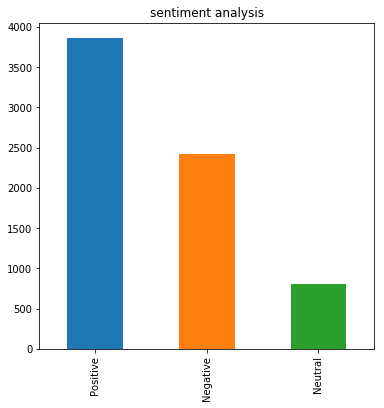

In [46]:
df_review.Sent_type.value_counts().plot (kind='bar' , title="sentiment analysis")